# TMLE Example Notebook

This notebook demonstrates the issue of using uplift curves without knowing true treatment effect and how to solve it by using TMLE as a proxy of the true treatment effect.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
import sys
import warnings
warnings.simplefilter("ignore", UserWarning)

from lightgbm import LGBMRegressor

In [8]:
import causalml

from causalml.dataset import synthetic_data
from causalml.inference.meta import BaseXRegressor, TMLELearner
from causalml.metrics.visualize import plot
from causalml.propensity import calibrate

print(causalml.__version__)

0.7.0


In [9]:
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)
plt.style.use('fivethirtyeight')

## Generating Synthetic Data

In [10]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=1000000, p=10, sigma=5.)

In [11]:
X_train, X_test, y_train, y_test, e_train, e_test, treatment_train, treatment_test, tau_train, tau_test, b_train, b_test = train_test_split(X, y, e, treatment, tau, b, test_size=0.5, random_state=42)

## Calculating Individual Treatment Effect (ITE/CATE)

In [12]:
# X Learner
learner_x = BaseXRegressor(learner=LGBMRegressor())
learner_x.fit(X=X_train, treatment=treatment_train, y=y_train)
cate_x_test = learner_x.predict(X=X_test, p=e_test, treatment=treatment_test).flatten()

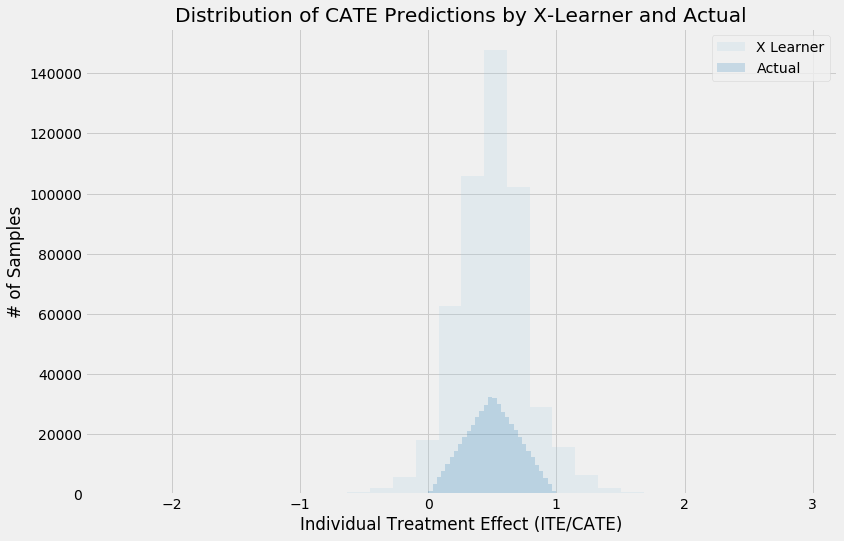

In [13]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))
plt.hist(cate_x_test, alpha=alpha, bins=bins, label='X Learner')
plt.hist(tau_test, alpha=alpha, bins=bins, label='Actual')

plt.title('Distribution of CATE Predictions by X-Learner and Actual')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
_=plt.legend()

## Validating CATE without TMLE

In [14]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'tau': tau_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

### Uplift Curve With Ground Truth

If true treatment effect is known as in simulations, the uplift curve of a model uses the cumulative sum of the treatment effect sorted by model's CATE estimate.

In the figure below, the uplift curve of X-learner shows positive lift close to the optimal lift by the ground truth.

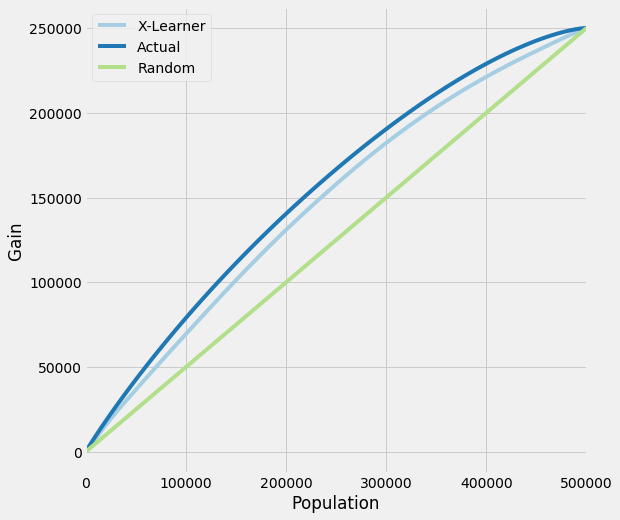

In [15]:
plot(df, outcome_col='y', treatment_col='w', treatment_effect_col='tau')

### Uplift Curve Without Ground Truth

If true treatment effect is unknown as in practice, the uplift curve of a model uses the cumulative mean difference of outcome in the treatment and control group sorted by model's CATE estimate.

In the figure below, the uplift curves of X-learner as well as the ground truth show no lift incorrectly.

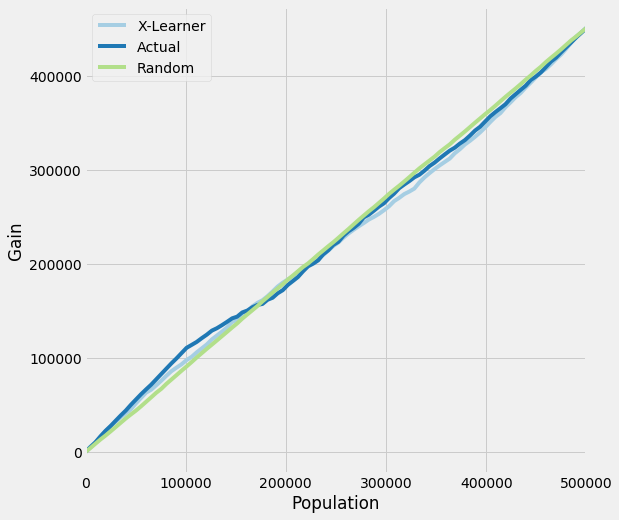

In [16]:
plot(df.drop('tau', axis=1), outcome_col='y', treatment_col='w')

## TMLE 

In [17]:
n_fold = 5
n_segment = 5

### TMLE Model Training

In [18]:
kf = KFold(n_splits=n_fold)

In [19]:
tmle = TMLELearner(learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300), 
                   cv=kf, calibrate_propensity=True)

ate_all, ate_all_lb, ate_all_ub = tmle.estimate_ate(X=X_test, p=e_test, treatment=treatment_test, y=y_test)

ate_all, ate_all_lb, ate_all_ub

(array([0.50768317]), array([0.46935004]), array([0.5460163]))

In [20]:
tmle = TMLELearner(learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300), 
                   cv=kf, calibrate_propensity=True)

ate_actual, ate_actual_lb, ate_actual_ub = tmle.estimate_ate(X=X_test, p=e_test, treatment=treatment_test, y=y_test, segment=pd.qcut(tau_test, n_segment, labels=False))

ate_actual, ate_actual_lb, ate_actual_ub

(array([[0.18266498, 0.40616549, 0.52370452, 0.53050438, 0.89950906]]),
 array([[0.08777372, 0.3316701 , 0.45398087, 0.43915581, 0.80278185]]),
 array([[0.27755624, 0.48066088, 0.59342817, 0.62185295, 0.99623627]]))

In [21]:
tmle = TMLELearner(learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300), 
                   cv=kf, calibrate_propensity=True)

ate_xlearner, ate_xlearner_lb, ate_xlearner_ub = tmle.estimate_ate(X=X_test, p=e_test, treatment=treatment_test, y=y_test, segment=pd.qcut(cate_x_test, n_segment, labels=False))

ate_xlearner, ate_xlearner_lb, ate_xlearner_ub

(array([[0.3163289 , 0.35757709, 0.52234297, 0.61638953, 0.72640924]]),
 array([[0.22555242, 0.27778549, 0.44224462, 0.52554748, 0.63803503]]),
 array([[0.40710537, 0.4373687 , 0.60244131, 0.70723158, 0.81478345]]))

### Uplift Curve with TMLE as Ground Truth

By using TMLE as a proxy of the ground truth, the uplift curves of X-learner and the ground truth become close to the original using the ground truth.

Text(0,0.5,'Lift in GB')

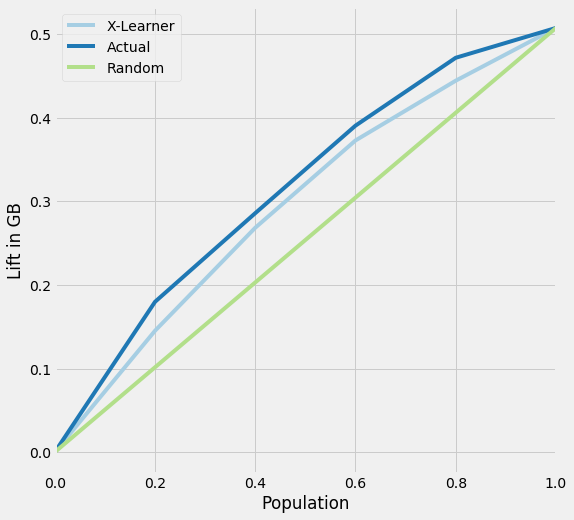

In [22]:
lift_actual = [0.] * (n_segment + 1)
lift_actual[n_segment] = ate_all[0]

lift_xlearner = [0.] * (n_segment + 1)
lift_xlearner[n_segment] = ate_all[0]

for i in range(1, n_segment):
    lift_actual[i] = ate_actual[0][n_segment - i] * .2 + lift_actual[i - 1]
    lift_xlearner[i] = ate_xlearner[0][n_segment - i] * .2 + lift_xlearner[i - 1]     

pd.DataFrame({'Population': np.linspace(0, 1, n_segment + 1),
              'Actual': lift_actual,
              'X-Learner': lift_xlearner,
              'Random': np.linspace(0, 1, n_segment + 1)*lift_actual[-1]}).plot(x='Population', 
                                                                                y=['X-Learner', 'Actual', 'Random'], 
                                                                                figsize=(8, 8))
plt.ylabel('Lift in GB')

### Uplift Curve with TMLE as Ground Truth Direct API Call

In [23]:
df = pd.DataFrame({'y': y_test, 'w': treatment_test, 'p': e_test, 'X-Learner': cate_x_test, 'Actual': tau_test})

In [24]:
inference_cols = []
for i in range(X_test.shape[1]):
    col = 'col_' + str(i)
    df[col] = X_test[:,i]
    inference_cols.append(col)

In [25]:
df.head()

,y,w,p,X-Learner,Actual,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9
0,6.379701,1,0.594251,0.510393,0.450937,0.479095,0.422779,0.932997,0.917603,0.378047,0.091740,0.169296,0.181263,0.941201,0.203647
1,7.856663,1,0.100000,0.202688,0.221944,0.015082,0.428805,0.158846,0.421723,0.780089,0.582120,0.312353,0.138003,0.371170,0.536153
2,0.219404,0,0.100000,0.186551,0.346224,0.000338,0.692109,0.810690,0.212941,0.060427,0.073460,0.670384,0.673465,0.963683,0.971302
3,5.787478,0,0.633119,1.158979,0.885359,0.839687,0.931031,0.225392,0.437308,0.981599,0.138600,0.747368,0.608712,0.993465,0.247119
4,5.406358,1,0.100000,0.406241,0.031567,0.016022,0.047113,0.190195,0.987028,0.364109,0.501047,0.915168,0.301516,0.691074,0.770827


In [27]:
tmle_df = get_tmlegain(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                       inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                       n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

In [28]:
tmle_df

,X-Learner,Actual,Random
0.0,0.000000,0.000000,0.000000
0.2,0.145282,0.179902,0.101537
0.4,0.268560,0.286003,0.203073
0.6,0.373028,0.390744,0.304610
0.8,0.444544,0.471977,0.406147
1.0,0.507683,0.507683,0.507683


#### Uplift Curve

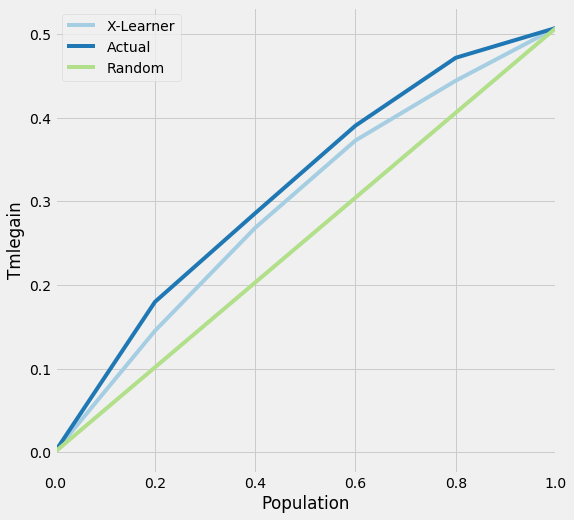

In [29]:
plot_tmlegain(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

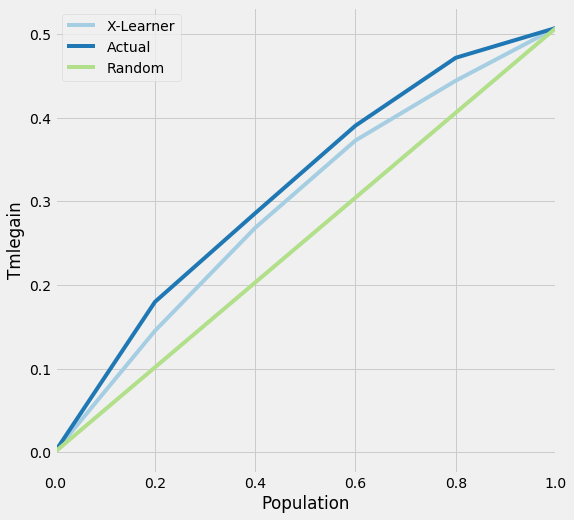

In [30]:
plot(df, kind='tmlegain', learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

#### AUUC Score

In [31]:
auuc_score_tmle(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

X-Learner    0.289849
Actual       0.306051
Random       0.253842
dtype: float64

### Uplift Curve with TMLE as Ground Truth Direct API Call including CI

In [32]:
tmle_df = get_tmlegain(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                   inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                   n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

In [33]:
tmle_df

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB,Random
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.2,0.145282,0.179902,0.127607,0.160556,0.162957,0.199247,0.101537
0.4,0.268560,0.286003,0.232717,0.248388,0.304403,0.323618,0.203073
0.6,0.373028,0.390744,0.321165,0.339184,0.424891,0.442303,0.304610
0.8,0.444544,0.471977,0.376723,0.405518,0.512365,0.538436,0.406147
1.0,0.507683,0.507683,0.469350,0.469350,0.546016,0.546016,0.507683


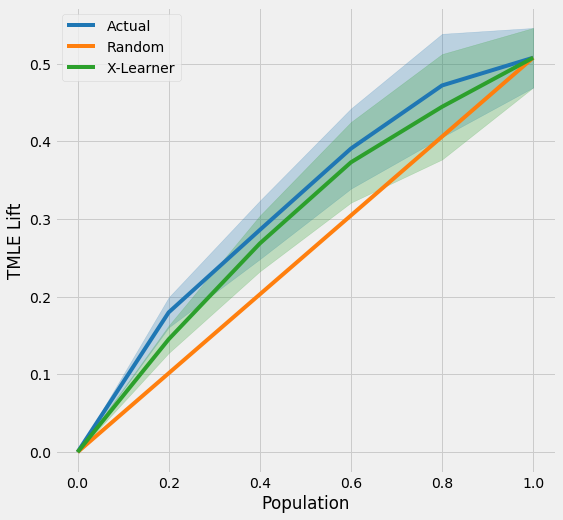

In [34]:
plot_tmlegain(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

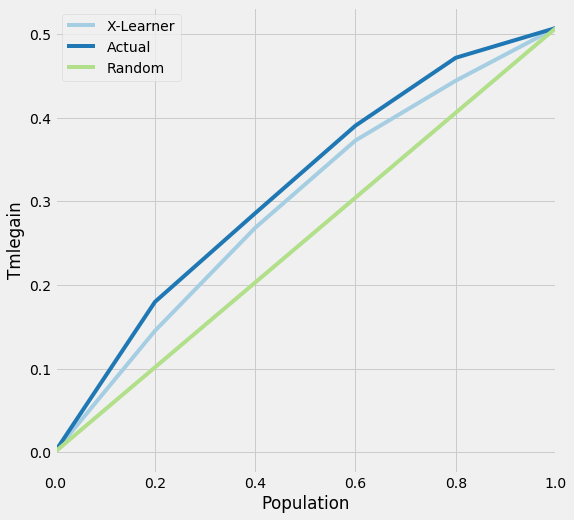

In [35]:
plot(df, kind='tmlegain', ci=True, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True)

### Qini Curve with TMLE as Ground Truth Direct API Call

In [36]:
qini = get_tmleqini(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                    inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                    n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

In [37]:
qini

,X-Learner,Actual,Random
0,0.000000,0.000000,0.000000
1,50653.242757,73549.257790,26411.912128
2,96375.785223,117117.460532,52823.824255
3,128073.123470,144030.112134,79235.736383
4,140817.171045,156721.565211,105647.648510
5,132059.560638,132059.560638,132059.560638


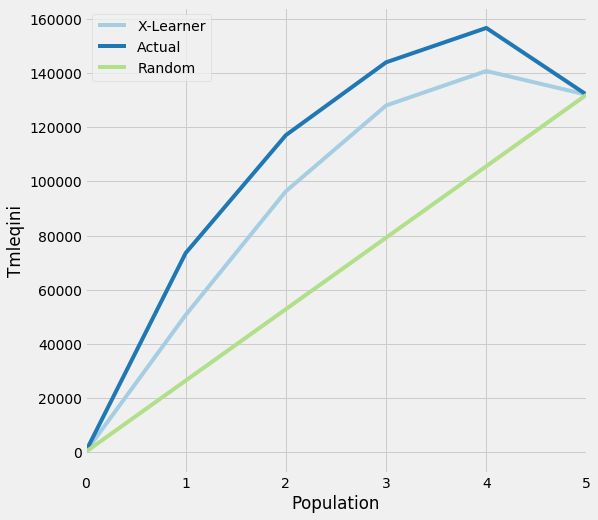

In [38]:
plot_tmleqini(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
              inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

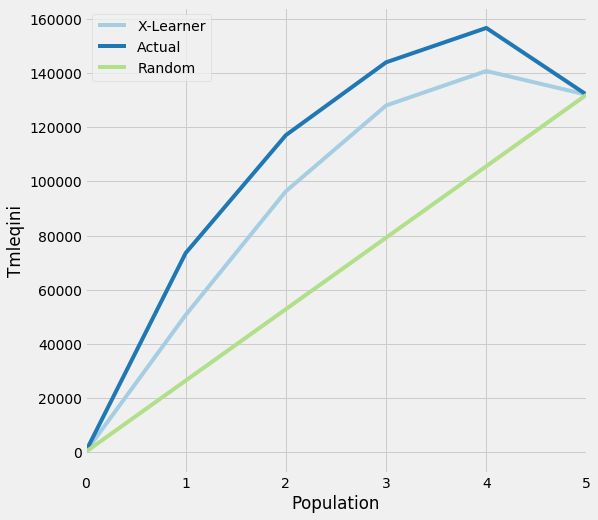

In [39]:
plot(df, kind='tmleqini', learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

#### Qini Score

In [40]:
qini_score_tmle(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                n_segment=5, cv=kf, calibrate_propensity=True, ci=False)

X-Learner    25300.033537
Actual       37883.212399
Random           0.000000
dtype: float64

### Qini Curve with TMLE as Ground Truth Direct API Call including CI

In [41]:
qini = get_tmleqini(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
                    inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
                    n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

In [42]:
qini

,X-Learner,Actual,X-Learner LB,Actual LB,X-Learner UB,Actual UB,Random
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,50653.242757,73549.257790,44490.820965,65640.260809,56815.664550,81458.254770,26411.912128
2,96375.785223,117117.460532,83474.881835,101706.370942,109276.688610,132528.550122,52823.824255
3,128073.123470,144030.112134,110311.612152,125035.993928,145834.634789,163024.230341,79235.736383
4,140817.171045,156721.565211,120211.886983,135399.689590,161422.455108,178043.440832,105647.648510
5,132059.560638,132059.560638,132059.560638,132059.560638,132059.560638,132059.560638,132059.560638


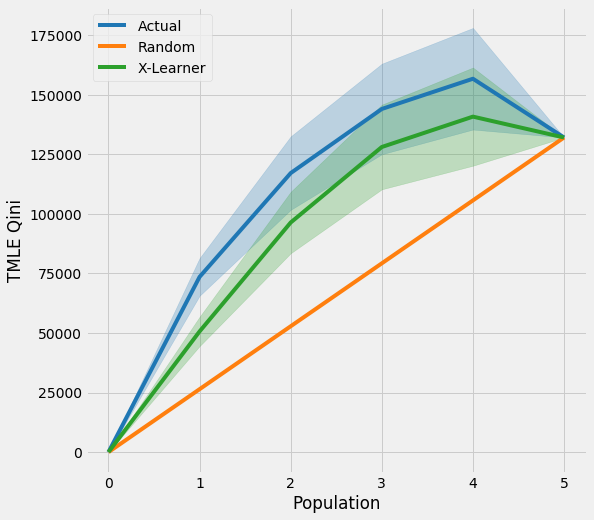

In [43]:
plot_tmleqini(df, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
              inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
              n_segment=5, cv=kf, calibrate_propensity=True, ci=True)

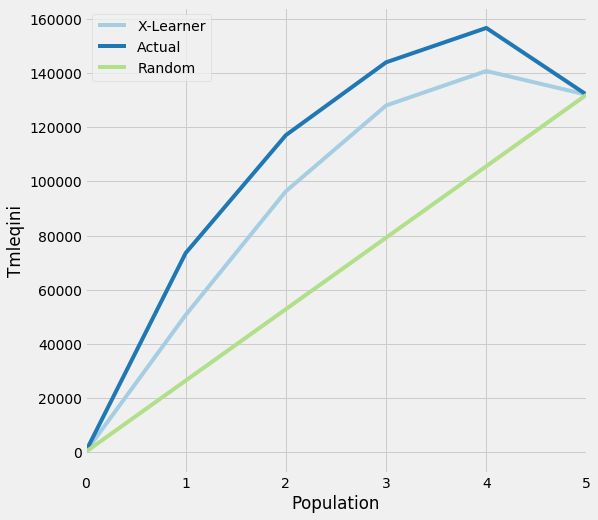

In [44]:
plot(df, kind='tmleqini', ci=True, learner=LGBMRegressor(num_leaves=64, learning_rate=.05, n_estimators=300),
     inference_col=inference_cols, outcome_col='y', treatment_col='w', p_col='p',
     n_segment=5, cv=kf, calibrate_propensity=True)